# Python Package Manager Energy Analysis

This notebook is designed for the following research questions:
- **RQ1 (Installation):** energy differences by tool in `cold` and `warm`; plus `cold vs warm` within tool.
- **RQ2 (Correlation):** relationship between execution time and energy.
- **RQ3 (Resolution):** energy differences by tool in `lock` mode.

**Data policy:** energy/time metrics are computed from EnergiBridge `.csv` files only.
`.meta.csv` files are used only for run verification (e.g., exit code, sanity checks).


In [49]:
import warnings
from itertools import combinations
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

warnings.filterwarnings('ignore', category=RuntimeWarning)
sns.set_theme(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', 200)

# Point this to the dataset you want to analyze.
RESULTS_DIR = Path('results/Final results')

print(f'Reading results from: {RESULTS_DIR.resolve()}')
if not RESULTS_DIR.exists():
    raise FileNotFoundError(f'Directory does not exist: {RESULTS_DIR}')


Reading results from: C:\Users\Dani\Desktop\Workspace\University\MSc\Q3\CS4575-Sustainable-Software-Engineering\python-package-manager-energy-benchmark\results\Final results


In [50]:
def parse_result_filename(file_path: Path):
    """Parse names like tool_mode_os_arch_YYYYMMDD_HHMMSS.csv."""
    stem = file_path.stem
    parts = stem.split('_')

    # Ignore sidecar/meta/schedule-like files early.
    if stem.startswith('schedule_') or stem.endswith('.meta'):
        return None
    if len(parts) < 6:
        return None

    tool = parts[0].strip().lower()
    mode = parts[1].strip().lower()
    os_name = parts[2].strip().lower()
    arch = '_'.join(parts[3:-2]).strip().lower()
    timestamp = '_'.join(parts[-2:])

    if not tool or not mode or not os_name or not arch:
        return None

    return {
        'tool': tool,
        'mode': mode,
        'os': os_name,
        'arch': arch,
        'timestamp': timestamp,
    }


def holm_adjust(p_values):
    """Holm-Bonferroni adjusted p-values."""
    p_values = np.asarray(p_values, dtype=float)
    m = len(p_values)
    if m == 0:
        return np.array([])

    order = np.argsort(p_values)
    p_sorted = p_values[order]

    adj_sorted = np.empty(m, dtype=float)
    running_max = 0.0
    for i, p in enumerate(p_sorted):
        candidate = (m - i) * p
        running_max = max(running_max, candidate)
        adj_sorted[i] = min(1.0, running_max)

    adjusted = np.empty(m, dtype=float)
    adjusted[order] = adj_sorted
    return adjusted


def cliffs_delta(a, b):
    """Cliff's delta effect size."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m, n = len(a), len(b)
    if m == 0 or n == 0:
        return np.nan

    greater = 0
    lower = 0
    for x in a:
        greater += np.sum(x > b)
        lower += np.sum(x < b)

    return (greater - lower) / (m * n)


def cliffs_label(delta):
    if np.isnan(delta):
        return 'NA'
    ad = abs(delta)
    if ad < 0.147:
        return 'negligible'
    if ad < 0.33:
        return 'small'
    if ad < 0.474:
        return 'medium'
    return 'large'


def compute_run_metrics(csv_path: Path):
    df = pd.read_csv(csv_path)
    if df.empty:
        return None, 'empty_csv'

    # Coerce columns used for metric computation.
    for col in ['Delta', 'Time', 'SYSTEM_POWER (Watts)', 'PACKAGE_ENERGY (J)', 'CPU_ENERGY (J)']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Duration from Delta if present; fallback to monotonic Time differences.
    duration_s = np.nan
    duration_source = None

    if 'Delta' in df.columns:
        delta_ms = df['Delta'].dropna().clip(lower=0)
        if len(delta_ms) > 0:
            duration_s = delta_ms.sum() / 1000.0
            duration_source = 'delta_sum'

    if np.isnan(duration_s) and 'Time' in df.columns:
        t = df['Time'].dropna().values
        if len(t) >= 2:
            diffs = np.diff(t)
            diffs = np.clip(diffs, 0, None)
            duration_s = diffs.sum() / 1000.0
            duration_source = 'time_diff_sum'

    # Energy source preference: cumulative counters first, then power integration.
    energy_j = np.nan
    energy_source = None

    for counter_col in ['PACKAGE_ENERGY (J)', 'CPU_ENERGY (J)']:
        if counter_col in df.columns:
            series = df[counter_col].dropna()
            if len(series) >= 2:
                e = float(series.iloc[-1] - series.iloc[0])
                if np.isfinite(e) and e >= 0:
                    energy_j = e
                    energy_source = f'counter:{counter_col}'
                    break

    if np.isnan(energy_j) and 'SYSTEM_POWER (Watts)' in df.columns:
        if 'Delta' in df.columns:
            tmp = df[['SYSTEM_POWER (Watts)', 'Delta']].dropna().copy()
            if not tmp.empty:
                tmp['Delta'] = tmp['Delta'].clip(lower=0)
                energy_j = float((tmp['SYSTEM_POWER (Watts)'] * (tmp['Delta'] / 1000.0)).sum())
                energy_source = 'power_x_delta'
        elif 'Time' in df.columns:
            tmp = df[['SYSTEM_POWER (Watts)', 'Time']].dropna().copy()
            if len(tmp) >= 2:
                dt = pd.Series(tmp['Time']).diff().fillna(0).clip(lower=0) / 1000.0
                energy_j = float((tmp['SYSTEM_POWER (Watts)'] * dt).sum())
                energy_source = 'power_x_time_diff'

    if np.isnan(duration_s):
        return None, 'missing_duration'
    if np.isnan(energy_j):
        return None, 'missing_energy'

    return {
        'duration_s': float(duration_s),
        'energy_j': float(energy_j),
        'rows': int(len(df)),
        'duration_source': duration_source,
        'energy_source': energy_source,
    }, None


def tool_label(tool, mode):
    # Align lock-mode wording with RQ3 (pip-tools).
    if mode == 'lock' and tool == 'pip':
        return 'pip-tools'
    return tool


In [51]:
all_csv_files = sorted(RESULTS_DIR.glob('*.csv'))

records = []
exclusions = []

for file_path in all_csv_files:
    # Skip sidecar and schedule files.
    if file_path.name.endswith('.meta.csv') or file_path.name.startswith('schedule_'):
        continue

    parsed = parse_result_filename(file_path)
    if parsed is None:
        exclusions.append({'file': file_path.name, 'reason': 'bad_filename_pattern'})
        continue

    # Optional verification from .meta.csv (not used as metric input).
    meta_path = file_path.with_name(file_path.stem + '.meta.csv')
    meta_present = meta_path.exists()
    meta_exit_code = np.nan
    meta_wall_clock_s = np.nan

    if meta_present:
        try:
            meta_df = pd.read_csv(meta_path)
            if not meta_df.empty:
                row = meta_df.iloc[0]
                meta_exit_code = pd.to_numeric(row.get('exit_code', np.nan), errors='coerce')
                meta_wall_clock_s = pd.to_numeric(row.get('wall_clock_s', np.nan), errors='coerce')
        except Exception:
            exclusions.append({'file': file_path.name, 'reason': 'meta_parse_error'})
            continue

    metrics, reason = compute_run_metrics(file_path)
    if reason is not None:
        exclusions.append({'file': file_path.name, 'reason': reason})
        continue

    # Keep only verified-success runs if meta exists.
    if meta_present and np.isfinite(meta_exit_code) and int(meta_exit_code) != 0:
        exclusions.append({'file': file_path.name, 'reason': f'nonzero_exit_code:{int(meta_exit_code)}'})
        continue

    records.append({
        'file': file_path.name,
        'path': str(file_path),
        **parsed,
        **metrics,
        'meta_present': meta_present,
        'meta_exit_code': meta_exit_code,
        'meta_wall_clock_s': meta_wall_clock_s,
    })

runs = pd.DataFrame(records)
excl = pd.DataFrame(exclusions)

print(f'Total CSV files in folder: {len(all_csv_files)}')
print(f'Run CSV candidates: {len([f for f in all_csv_files if not f.name.endswith(".meta.csv") and not f.name.startswith("schedule_")])}')
print(f'Included runs: {len(runs)}')
print(f'Excluded runs: {len(excl)}')

if not excl.empty:
    print('\nExclusion reasons:')
    display(excl['reason'].value_counts().rename_axis('reason').to_frame('count'))

if runs.empty:
    raise RuntimeError('No valid runs found after QA.')

runs['tool_label'] = [tool_label(t, m) for t, m in zip(runs['tool'], runs['mode'])]

print('\nRun counts by mode x tool:')
counts = runs.groupby(['mode', 'tool_label']).size().rename('runs').reset_index()
display(counts.sort_values(['mode', 'tool_label']))

print('Energy sources used:')
display(runs['energy_source'].value_counts().rename_axis('energy_source').to_frame('count'))

print('Duration sources used:')
display(runs['duration_source'].value_counts().rename_axis('duration_source').to_frame('count'))

# Optional sanity check: compare Delta-derived duration vs meta wall-clock where available.
if runs['meta_present'].any() and runs['meta_wall_clock_s'].notna().any():
    check = runs[runs['meta_wall_clock_s'].notna()].copy()
    check['duration_diff_s'] = check['duration_s'] - check['meta_wall_clock_s']
    print('Duration sanity check against meta wall_clock_s (diagnostic only):')
    display(check[['file', 'duration_s', 'meta_wall_clock_s', 'duration_diff_s']].sort_values('file'))


Total CSV files in folder: 541
Run CSV candidates: 270
Included runs: 270
Excluded runs: 0

Run counts by mode x tool:


,mode,tool_label,runs
0,cold,pip,30
1,cold,poetry,30
2,cold,uv,30
3,lock,pip-tools,30
4,lock,poetry,30
5,lock,uv,30
6,warm,pip,30
7,warm,poetry,30
8,warm,uv,30


Energy sources used:


,count
energy_source,
power_x_delta,270


Duration sources used:


,count
duration_source,
delta_sum,270


Duration sanity check against meta wall_clock_s (diagnostic only):


,file,duration_s,meta_wall_clock_s,duration_diff_s
0,pip_cold_darwin_arm64_20260227_002225.csv,47.532,49,-1.468
1,pip_cold_darwin_arm64_20260227_002803.csv,45.587,46,-0.413
2,pip_cold_darwin_arm64_20260227_004417.csv,44.810,46,-1.190
3,pip_cold_darwin_arm64_20260227_012212.csv,44.270,45,-0.730
4,pip_cold_darwin_arm64_20260227_012636.csv,47.515,48,-0.485
...,...,...,...,...
265,uv_warm_darwin_arm64_20260227_071238.csv,0.631,1,-0.369
266,uv_warm_darwin_arm64_20260227_071349.csv,0.629,1,-0.371
267,uv_warm_darwin_arm64_20260227_071458.csv,0.631,2,-1.369
268,uv_warm_darwin_arm64_20260227_071856.csv,0.614,1,-0.386


## Descriptive Statistics
Summary statistics are reported at `mode x tool` granularity (not pooled globally across modes).


In [52]:
summary = (
    runs
    .groupby(['mode', 'tool_label'])
    .agg(
        runs=('energy_j', 'size'),
        energy_mean_j=('energy_j', 'mean'),
        energy_median_j=('energy_j', 'median'),
        energy_std_j=('energy_j', 'std'),
        duration_mean_s=('duration_s', 'mean'),
        duration_median_s=('duration_s', 'median'),
        duration_std_s=('duration_s', 'std'),
    )
    .reset_index()
    .sort_values(['mode', 'tool_label'])
)

print('Descriptive statistics by mode x tool')
display(summary)

print('Raw run-level data (first rows)')
display(runs[['file', 'mode', 'tool_label', 'energy_j', 'duration_s', 'rows', 'energy_source']].head(20))


Descriptive statistics by mode x tool


,mode,tool_label,runs,energy_mean_j,energy_median_j,energy_std_j,duration_mean_s,duration_median_s,duration_std_s
0,cold,pip,30,494.829638,394.655569,191.396069,45.599367,44.8460,2.241467
1,cold,poetry,30,81.951863,65.780555,33.742727,4.603767,4.5100,0.330099
2,cold,uv,30,113.179126,99.028684,30.262620,6.413233,6.2355,0.561283
3,lock,pip-tools,30,148.746005,118.254912,61.094715,13.893433,13.5020,1.219014
4,lock,poetry,30,66.653109,54.480919,27.389509,5.154800,4.9940,0.547441
5,lock,uv,30,2.149151,2.006489,1.302461,0.214567,0.2140,0.002528
6,warm,pip,30,308.162851,249.906372,113.889211,21.428933,20.8415,1.466628
7,warm,poetry,30,56.596274,51.111990,14.099153,3.406967,3.3130,0.160734
8,warm,uv,30,9.560078,8.154860,3.951730,0.608000,0.6195,0.121298


Raw run-level data (first rows)


,file,mode,tool_label,energy_j,duration_s,rows,energy_source
0,pip_cold_darwin_arm64_20260227_002225.csv,cold,pip,957.904829,47.532,236,power_x_delta
1,pip_cold_darwin_arm64_20260227_002803.csv,cold,pip,767.895867,45.587,226,power_x_delta
2,pip_cold_darwin_arm64_20260227_004417.csv,cold,pip,602.590880,44.810,222,power_x_delta
3,pip_cold_darwin_arm64_20260227_012212.csv,cold,pip,728.980432,44.270,220,power_x_delta
4,pip_cold_darwin_arm64_20260227_012636.csv,cold,pip,770.587283,47.515,236,power_x_delta
5,pip_cold_darwin_arm64_20260227_013203.csv,cold,pip,733.377439,49.780,247,power_x_delta
6,pip_cold_darwin_arm64_20260227_020943.csv,cold,pip,1025.257130,52.287,260,power_x_delta
7,pip_cold_darwin_arm64_20260227_024344.csv,cold,pip,690.881901,46.926,233,power_x_delta
8,pip_cold_darwin_arm64_20260227_025033.csv,cold,pip,453.219068,48.853,242,power_x_delta
9,pip_cold_darwin_arm64_20260227_031105.csv,cold,pip,392.060398,43.378,212,power_x_delta


## Visualizations
- Faceted distribution plots by scenario (`mode`) to avoid aggregation bias.
- RQ2 scatter plot for energy vs duration.


Saved: C:\Users\Dani\Desktop\Workspace\University\MSc\Q3\CS4575-Sustainable-Software-Engineering\python-package-manager-energy-benchmark\plots\report_figures\rq3_locking_violin.png


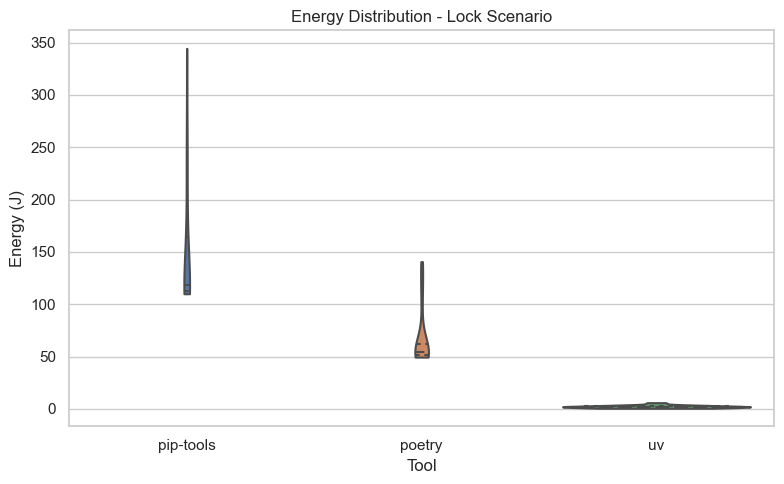

Saved: C:\Users\Dani\Desktop\Workspace\University\MSc\Q3\CS4575-Sustainable-Software-Engineering\python-package-manager-energy-benchmark\plots\report_figures\rq1_cold_violin.png


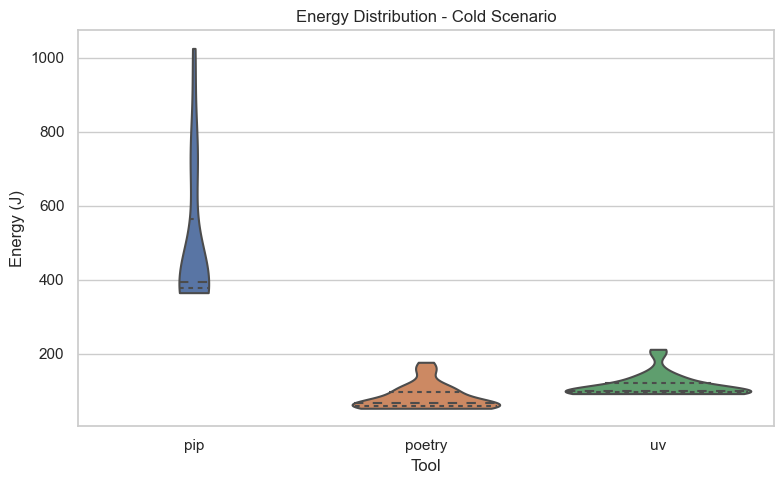

Saved: C:\Users\Dani\Desktop\Workspace\University\MSc\Q3\CS4575-Sustainable-Software-Engineering\python-package-manager-energy-benchmark\plots\report_figures\rq1_warm_violin.png


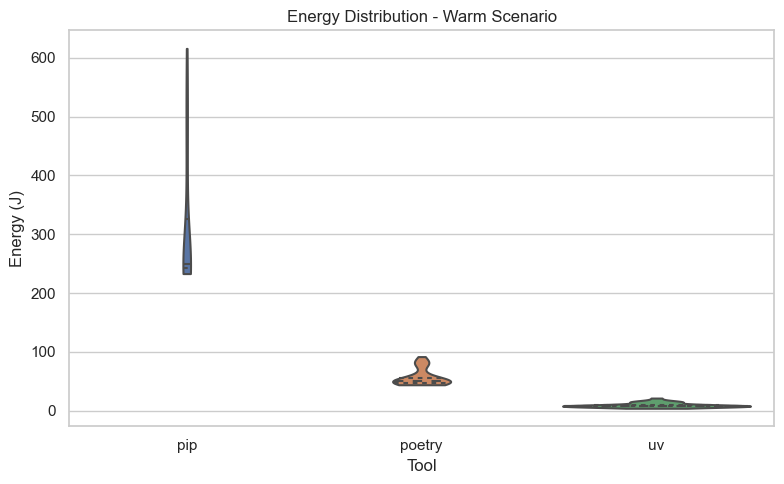

Saved: C:\Users\Dani\Desktop\Workspace\University\MSc\Q3\CS4575-Sustainable-Software-Engineering\python-package-manager-energy-benchmark\plots\report_figures\duration_by_mode_box.png


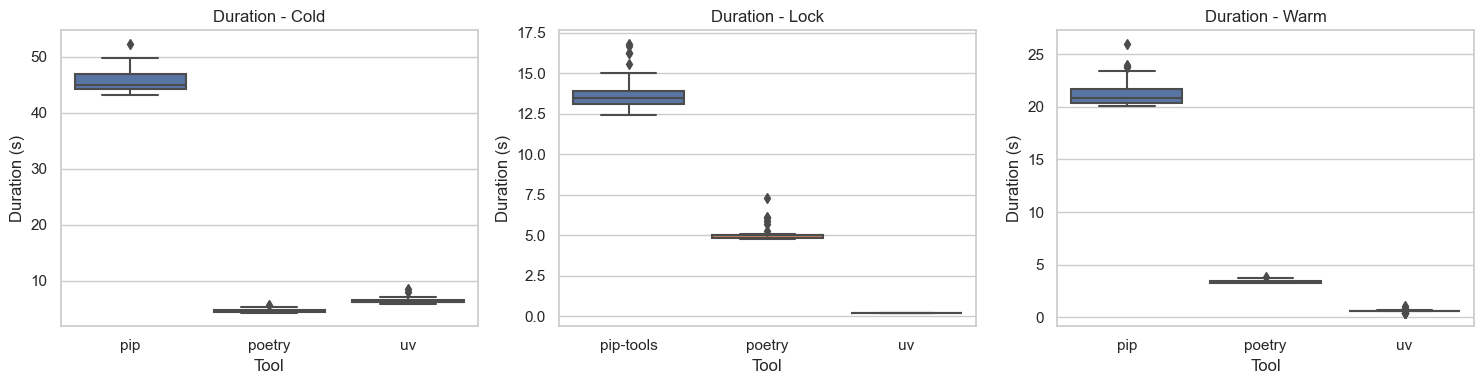

Saved: C:\Users\Dani\Desktop\Workspace\University\MSc\Q3\CS4575-Sustainable-Software-Engineering\python-package-manager-energy-benchmark\plots\report_figures\rq2_correlation_scatter.png


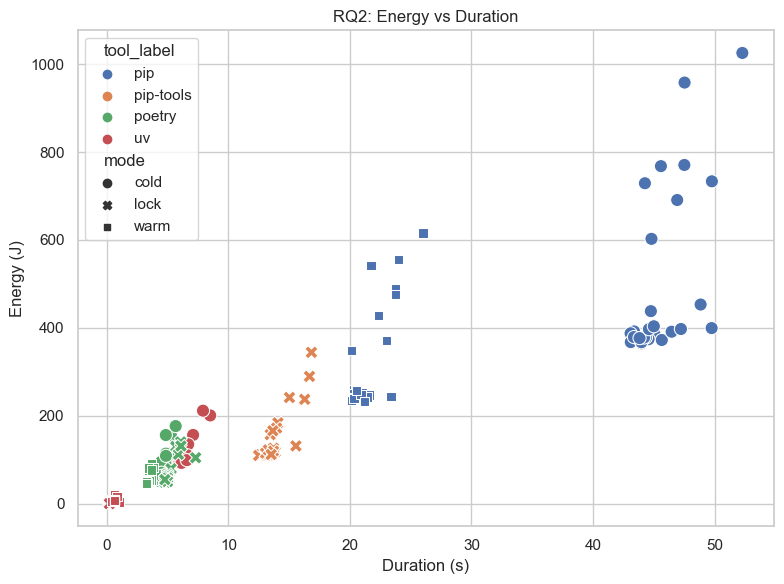

In [53]:
EXPORT_DIR = Path('plots/report_figures')
EXPORT_DIR.mkdir(parents=True, exist_ok=True)


def filter_tools_for_mode(df):
    """Exclude pip/pip-tools where they do not apply for the scenario."""
    filtered = []
    for mode, sub in df.groupby('mode', sort=False):
        if mode == 'lock':
            # In lock mode we report pip as pip-tools.
            sub = sub[sub['tool_label'] != 'pip']
        else:
            # In non-lock modes pip-tools is not a valid tool.
            sub = sub[sub['tool_label'] != 'pip-tools']
        filtered.append(sub)

    if not filtered:
        return df.iloc[0:0].copy()

    return pd.concat(filtered, ignore_index=True)


def scenario_tool_order(mode, labels):
    # Keep a consistent visual order across scenarios.
    # Lock mode uses pip-tools instead of pip.
    preferred = ['pip', 'pip-tools', 'poetry', 'uv']
    return [t for t in preferred if t in labels] + [t for t in sorted(labels) if t not in preferred]


plot_runs = filter_tools_for_mode(runs)


def save_energy_violin(mode, filename, log_scale=False):
    sub = plot_runs[plot_runs['mode'] == mode].copy()
    if sub.empty:
        print(f'Skipped {filename}: no data for mode={mode}')
        return

    order = scenario_tool_order(mode, sub['tool_label'].unique())

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.violinplot(
        data=sub,
        x='tool_label',
        y='energy_j',
        order=order,
        inner='quartile',
        cut=0,
        ax=ax,
    )

    if log_scale:
        ax.set_yscale('log')

    ax.set_title(f'Energy Distribution - {mode.capitalize()} Scenario')
    ax.set_xlabel('Tool')
    ax.set_ylabel('Energy (J)')
    fig.tight_layout()

    output_path = EXPORT_DIR / filename
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f'Saved: {output_path.resolve()}')
    plt.show()


# Report figures (energy)
save_energy_violin(mode='lock', filename='rq3_locking_violin.png', log_scale=False)
save_energy_violin(mode='cold', filename='rq1_cold_violin.png', log_scale=False)
save_energy_violin(mode='warm', filename='rq1_warm_violin.png', log_scale=False)

# Optional duration figure for replication package completeness.
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
mode_order = [m for m in ['cold', 'lock', 'warm'] if m in set(plot_runs['mode'])]
for ax, mode in zip(axes, mode_order):
    sub = plot_runs[plot_runs['mode'] == mode].copy()
    order = scenario_tool_order(mode, sub['tool_label'].unique())
    sns.boxplot(data=sub, x='tool_label', y='duration_s', order=order, ax=ax)
    ax.set_title(f'Duration - {mode.capitalize()}')
    ax.set_xlabel('Tool')
    ax.set_ylabel('Duration (s)')
fig.tight_layout()
duration_path = EXPORT_DIR / 'duration_by_mode_box.png'
fig.savefig(duration_path, dpi=300, bbox_inches='tight')
print(f'Saved: {duration_path.resolve()}')
plt.show()

# RQ2 scatter figure.
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=plot_runs,
    x='duration_s',
    y='energy_j',
    hue='tool_label',
    hue_order=['pip', 'pip-tools', 'poetry', 'uv'],
    style='mode',
    style_order=['cold', 'lock', 'warm'],
    s=90,
    ax=ax,
)
ax.set_title('RQ2: Energy vs Duration')
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Energy (J)')
fig.tight_layout()
scatter_path = EXPORT_DIR / 'rq2_correlation_scatter.png'
fig.savefig(scatter_path, dpi=300, bbox_inches='tight')
print(f'Saved: {scatter_path.resolve()}')
plt.show()





## RQ2 Correlation
Spearman correlation is reported overall and per mode.


In [54]:
def spearman_table(df, group_col=None):
    rows = []

    if group_col is None:
        d = df[['duration_s', 'energy_j']].dropna()
        if len(d) >= 3:
            rho, p = stats.spearmanr(d['duration_s'], d['energy_j'])
            rows.append({'scope': 'overall', 'n': len(d), 'spearman_rho': rho, 'p_value': p})
        return pd.DataFrame(rows)

    for g in sorted(df[group_col].unique()):
        d = df[df[group_col] == g][['duration_s', 'energy_j']].dropna()
        if len(d) >= 3:
            rho, p = stats.spearmanr(d['duration_s'], d['energy_j'])
            rows.append({'scope': f'{group_col}={g}', 'n': len(d), 'spearman_rho': rho, 'p_value': p})
    return pd.DataFrame(rows)

corr_overall = spearman_table(runs)
corr_by_mode = spearman_table(runs, 'mode')

print('Spearman correlation (overall)')
display(corr_overall)

print('Spearman correlation (by mode)')
display(corr_by_mode)


Spearman correlation (overall)


,scope,n,spearman_rho,p_value
0,overall,270,0.963808,6.792371e-156


Spearman correlation (by mode)


,scope,n,spearman_rho,p_value
0,mode=cold,90,0.922586,3.644219e-38
1,mode=lock,90,0.914158,2.859587e-36
2,mode=warm,90,0.937558,3.943437e-42


## Inference Pipeline
Per mode:
1. Optional normality diagnostics (Shapiro; only when enough points).
2. Omnibus test (Kruskal-Wallis).
3. Pairwise Mann-Whitney U with Holm correction.
4. Cliff's delta effect size.


In [55]:
alpha = 0.05

for mode in sorted(runs['mode'].unique()):
    sub = runs[runs['mode'] == mode].copy()
    tools = sorted(sub['tool_label'].unique())

    print(f'\n=== MODE: {mode.upper()} ===')
    print('n by tool:')
    display(sub.groupby('tool_label').size().rename('n').to_frame())

    # Normality diagnostics (not a hard gate, but reported for transparency).
    shapiro_rows = []
    for tool in tools:
        vals = sub[sub['tool_label'] == tool]['energy_j'].dropna().values
        if len(vals) >= 3:
            W, p = stats.shapiro(vals)
            shapiro_rows.append({'tool': tool, 'n': len(vals), 'W': W, 'p_value': p})
    if shapiro_rows:
        print('Shapiro-Wilk by tool (energy):')
        display(pd.DataFrame(shapiro_rows))
    else:
        print('Shapiro-Wilk skipped (insufficient n per group).')

    # Omnibus Kruskal-Wallis.
    grouped_vals = [sub[sub['tool_label'] == t]['energy_j'].dropna().values for t in tools]
    grouped_vals = [v for v in grouped_vals if len(v) > 0]

    if len(grouped_vals) >= 2:
        H, p_kw = stats.kruskal(*grouped_vals)
        print(f'Kruskal-Wallis: H={H:.4f}, p={p_kw:.4g}')
    else:
        print('Kruskal-Wallis skipped (fewer than 2 groups).')
        continue

    # Pairwise tests + Holm correction.
    pairs = []
    for a, b in combinations(tools, 2):
        va = sub[sub['tool_label'] == a]['energy_j'].dropna().values
        vb = sub[sub['tool_label'] == b]['energy_j'].dropna().values
        if len(va) == 0 or len(vb) == 0:
            continue

        U, p = stats.mannwhitneyu(va, vb, alternative='two-sided')
        d = cliffs_delta(va, vb)
        pairs.append({
            'mode': mode,
            'a': a,
            'b': b,
            'n_a': len(va),
            'n_b': len(vb),
            'U': U,
            'p_uncorrected': p,
            'cliffs_delta': d,
            'effect_magnitude': cliffs_label(d),
        })

    if not pairs:
        print('No pairwise comparisons available.')
        continue

    pair_df = pd.DataFrame(pairs)
    pair_df['p_holm'] = holm_adjust(pair_df['p_uncorrected'].values)
    pair_df['significant_holm'] = pair_df['p_holm'] < alpha
    display(pair_df.sort_values('p_holm'))



=== MODE: COLD ===
n by tool:


,n
tool_label,
pip,30
poetry,30
uv,30


Shapiro-Wilk by tool (energy):


,tool,n,W,p_value
0,pip,30,0.684159,9.251217e-07
1,poetry,30,0.777743,2.643898e-05
2,uv,30,0.676540,7.235186e-07


Kruskal-Wallis: H=66.3564, p=3.898e-15


,mode,a,b,n_a,n_b,U,p_uncorrected,cliffs_delta,effect_magnitude,p_holm,significant_holm
0,cold,pip,poetry,30,30,900.0,3.019859e-11,1.000000,large,9.059578e-11,True
1,cold,pip,uv,30,30,900.0,3.019859e-11,1.000000,large,9.059578e-11,True
2,cold,poetry,uv,30,30,182.0,7.658787e-05,-0.595556,large,7.658787e-05,True



=== MODE: LOCK ===
n by tool:


,n
tool_label,
pip-tools,30
poetry,30
uv,30


Shapiro-Wilk by tool (energy):


,tool,n,W,p_value
0,pip-tools,30,0.678658,7.744150e-07
1,poetry,30,0.629136,1.687575e-07
2,uv,30,0.915556,2.060078e-02


Kruskal-Wallis: H=73.4457, p=1.126e-16


,mode,a,b,n_a,n_b,U,p_uncorrected,cliffs_delta,effect_magnitude,p_holm,significant_holm
1,lock,pip-tools,uv,30,30,900.0,3.019859e-11,1.000000,large,9.059578e-11,True
2,lock,poetry,uv,30,30,900.0,3.019859e-11,1.000000,large,9.059578e-11,True
0,lock,pip-tools,poetry,30,30,830.0,2.015221e-08,0.844444,large,2.015221e-08,True



=== MODE: WARM ===
n by tool:


,n
tool_label,
pip,30
poetry,30
uv,30


Shapiro-Wilk by tool (energy):


,tool,n,W,p_value
0,pip,30,0.654329,3.602829e-07
1,poetry,30,0.749419,8.911989e-06
2,uv,30,0.852484,6.992104e-04


Kruskal-Wallis: H=79.1209, p=6.594e-18


,mode,a,b,n_a,n_b,U,p_uncorrected,cliffs_delta,effect_magnitude,p_holm,significant_holm
0,warm,pip,poetry,30,30,900.0,3.019859e-11,1.0,large,9.059578e-11,True
1,warm,pip,uv,30,30,900.0,3.019859e-11,1.0,large,9.059578e-11,True
2,warm,poetry,uv,30,30,900.0,3.019859e-11,1.0,large,9.059578e-11,True


## RQ1-specific: Cold vs Warm Within Tool
This section runs only if both `cold` and `warm` are present for a given tool.


In [56]:
rq1_rows = []

for tool in sorted(runs['tool_label'].unique()):
    sub = runs[runs['tool_label'] == tool]
    cold = sub[sub['mode'] == 'cold']['energy_j'].dropna().values
    warm = sub[sub['mode'] == 'warm']['energy_j'].dropna().values

    if len(cold) == 0 or len(warm) == 0:
        continue

    U, p = stats.mannwhitneyu(cold, warm, alternative='two-sided')
    d = cliffs_delta(cold, warm)
    rq1_rows.append({
        'tool': tool,
        'n_cold': len(cold),
        'n_warm': len(warm),
        'U': U,
        'p_uncorrected': p,
        'cliffs_delta': d,
        'effect_magnitude': cliffs_label(d),
    })

if rq1_rows:
    rq1_df = pd.DataFrame(rq1_rows)
    rq1_df['p_holm'] = holm_adjust(rq1_df['p_uncorrected'].values)
    rq1_df['significant_holm'] = rq1_df['p_holm'] < 0.05
    print('RQ1 cold vs warm (within-tool)')
    display(rq1_df.sort_values('p_holm'))
else:
    print('No tool has both cold and warm runs in this dataset yet; RQ1 within-tool test skipped.')


RQ1 cold vs warm (within-tool)


,tool,n_cold,n_warm,U,p_uncorrected,cliffs_delta,effect_magnitude,p_holm,significant_holm
2,uv,30,30,900.0,3.019859e-11,1.000000,large,9.059578e-11,True
0,pip,30,30,766.0,3.093891e-06,0.702222,large,6.187781e-06,True
1,poetry,30,30,765.0,3.324153e-06,0.700000,large,6.187781e-06,True
